# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

### Первичное изучение данных

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
def df_info(df): #Функция для вывода основной информации о данных
    display(df.head())
    print(df.info())
    print('------------------------------------------------------------')
    print('Описание данных')
    print(df.describe())
    
def dropping(info): #Функция для удаления аномальных значений
    global df
    outlires = df.query(info).index 
    df = df.drop(index=outlires)
    
def uniq(row): #Функция для вывода количества уникальных значений столбца
    print('Уникальные значения в датафрейме для обучения (df)')
    print(df[row].value_counts())
    print('---------------------------------------------------------------------------------------------------')
    print('Уникальные значения в датафрейме для теста (df_test)')
    print(df_test[row].value_counts())
    
def costing(df): #Функция для подсчета стоимости проживания
    for i in range (len(df)): #Создание новых столбцов с ценой номера за сутки и ценой разового обслуживания исходя из категории номера
        if df['reserved_room_type'][i] == 'A':
            df['room_cost'][i] = 1000
            df['service'][i] = 400 
        elif df['reserved_room_type'][i] == 'B':
            df['room_cost'][i] = 800
            df['service'][i] = 350
        elif df['reserved_room_type'][i] == 'C':
            df['room_cost'][i] = 600
            df['service'][i] = 350 
        elif df['reserved_room_type'][i] == 'D':
            df['room_cost'][i] = 550
            df['service'][i] = 150 
        elif df['reserved_room_type'][i] == 'E':
            df['room_cost'][i] = 500
            df['service'][i] = 150 
        elif df['reserved_room_type'][i] == 'F':
            df['room_cost'][i] = 450
            df['service'][i] = 150 
        elif df['reserved_room_type'][i] == 'G':
            df['room_cost'][i] = 350
            df['service'][i] = 150 
            
    for i in range (len(df)): #Подсчет стоимости
        if df['arrival_date_month'][i] in ['September','October','November','March','April','May']: #Проверка на осень или весну
            df['season_cost'][i] = df['room_cost'][i]*1.2 #подсчет цены номера с учетом сезонности
            if df['total_nights'][i]>3: #Проверка на количество дней прибывания для дальнейшего расчета стоимости разового обслуживания
                df['total'][i] = (df['season_cost'][i]*df['total_nights'][i])+math.ceil(df['total_nights'][i]/2)*df['service'][i]
            else:
                df['total'][i] = (df['season_cost'][i]*df['total_nights'][i])+df['service'][i]
            
            
        elif df['arrival_date_month'][i] in ['June','July','August']: #Проверка на лето
            df['season_cost'][i] = df['room_cost'][i]*1.4
            if df['total_nights'][i]>3:
                df['total'][i] = (df['season_cost'][i]*df['total_nights'][i])+math.ceil(df['total_nights'][i]/2)*df['service'][i]
            else:
                df['total'][i] = (df['season_cost'][i]*df['total_nights'][i])+df['service'][i]
                    
        else:
            df['season_cost'][i] = df['room_cost'][i]
            if df['total_nights'][i]>3:
                df['total'][i] = (df['season_cost'][i]*df['total_nights'][i])+math.ceil(df['total_nights'][i]/2)*df['service'][i]
            else:
                df['total'][i] = (df['season_cost'][i]*df['total_nights'][i])+df['service'][i]
            
        if df['is_canceled'][i] == 1: #Итоговая проверка на отмену бронирования
            df['total_with_canceled'][i] = (df['season_cost'][i] + df['service'][i])*(-1)
        else:
            df['total_with_canceled'][i] = df['total'][i]
            
def roc(model,features,target): #Функция для определения значения метрики AUC-ROC и вывода на экран графика
    probabilities = model.predict_proba(features) 
    probabilities_one = probabilities[:, 1]
    auc_roc = roc_auc_score(target, probabilities_one)
    print('Значение AUC-ROC:', auc_roc)
    fpr, tpr, thresholds = roc_curve(target, probabilities_one)
    plt.figure()
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

In [3]:
df = pd.read_csv('/datasets/hotel_train.csv')
df_test = pd.read_csv('/datasets/hotel_test.csv')

In [4]:
df_info(df)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [5]:
df_info(df_test)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

Пропусков в данных не обнаружено, данные почти готовы к использованию, нужно только изменить тип данных в столбцах `lead_time`,`adults`,`children`,`babies` с float на integet. Также обнаружено аномальное значение в столбце `babies` равное 10 и значения больше 1 в столбце `required_car_parking_spaces`

### Предобработка и исследовательский анализ данных

In [6]:
print(df.duplicated().mean())
print(df_test.duplicated().mean())#Проверка на наличие явных дубликатов

0.0
0.0


Явных дубликатов обнаружено не было

In [7]:
uniq('meal')

Уникальные значения в датафрейме для обучения (df)
BB           51697
HB            7292
SC            5274
SC             515
FB             451
Name: meal, dtype: int64
---------------------------------------------------------------------------------------------------
Уникальные значения в датафрейме для теста (df_test)
BB           24684
SC            5035
HB            2399
SC             258
FB              36
Name: meal, dtype: int64


В столбце `meal` были обнаружены дубликаты названий, отличающееся скорее всего пробелами

In [8]:
df['meal'] = df['meal'].str.strip()
df_test['meal'] = df['meal'].str.strip()
uniq('meal')

Уникальные значения в датафрейме для обучения (df)
BB    51697
HB     7292
SC     5789
FB      451
Name: meal, dtype: int64
---------------------------------------------------------------------------------------------------
Уникальные значения в датафрейме для теста (df_test)
BB    25265
HB     4745
SC     1951
FB      451
Name: meal, dtype: int64


Были убраны дубликаты в столбце `meal`

In [9]:
uniq('reserved_room_type')

Уникальные значения в датафрейме для обучения (df)
A                   50501
D                    9387
E                    2448
F                    1213
B                     860
G                     592
C                     228
Name: reserved_room_type, dtype: int64
---------------------------------------------------------------------------------------------------
Уникальные значения в датафрейме для теста (df_test)
A                   23471
D                    6123
E                    1644
F                     503
G                     278
C                     201
B                     192
Name: reserved_room_type, dtype: int64


В столбце `reserved_room_type` присутствуют лишние пробелы, которые могут помешать дальнейшему анализу

In [10]:
df['reserved_room_type'] = df['reserved_room_type'].str.strip()
df_test['reserved_room_type'] = df['reserved_room_type'].str.strip()
uniq('reserved_room_type')

Уникальные значения в датафрейме для обучения (df)
A    50501
D     9387
E     2448
F     1213
B      860
G      592
C      228
Name: reserved_room_type, dtype: int64
---------------------------------------------------------------------------------------------------
Уникальные значения в датафрейме для теста (df_test)
A    24075
D     4558
E     1987
F      683
G      523
B      365
C      221
Name: reserved_room_type, dtype: int64


Лишние пробелы в столбце `reserved_room_type` были убраны

In [11]:
#Привод данных к правильному типу
df[['lead_time','adults','children','babies']] = df[['lead_time','adults','children','babies']].astype(int) 
df_test[['lead_time','adults','children','babies']] = df_test[['lead_time','adults','children','babies']].astype(int)

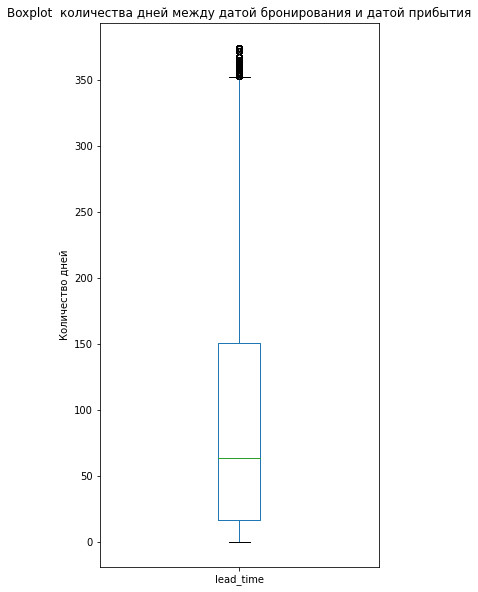

In [12]:
plt.figure(figsize=(5,10))
plt.title('Boxplot  количества дней между датой бронирования и датой прибытия')
plt.ylabel("Количество дней")
df['lead_time'].plot(kind='box');

AxesSubplot(0.125,0.125;0.775x0.755)


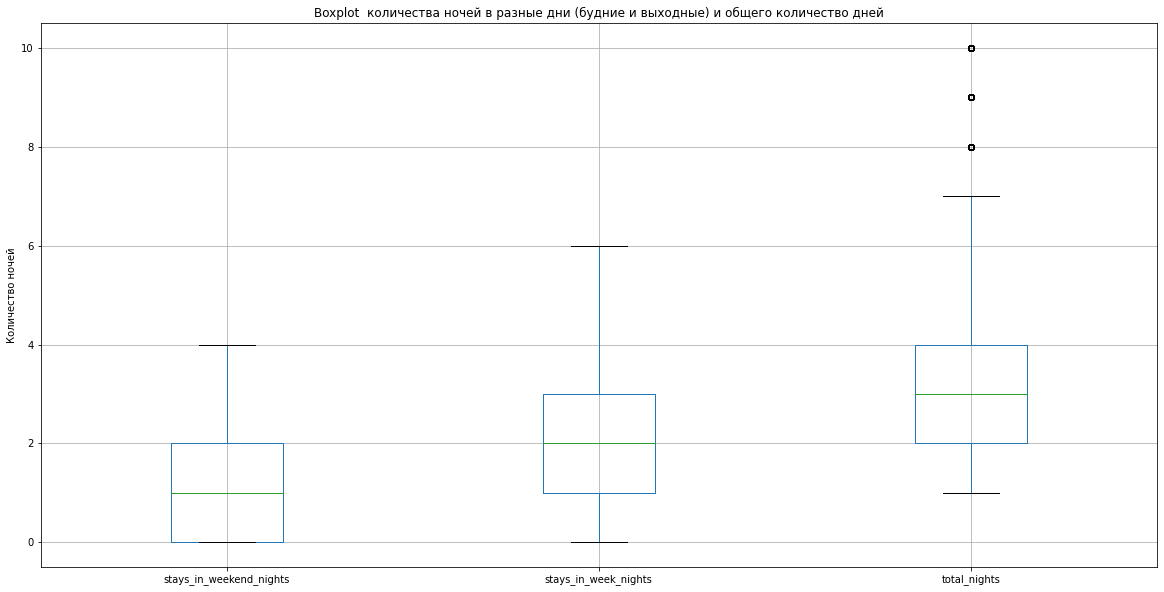

In [13]:
plt.figure(figsize=(20,10))
plt.title('Boxplot  количества ночей в разные дни (будние и выходные) и общего количество дней')
plt.ylabel("Количество ночей")
print(df[['stays_in_weekend_nights','stays_in_week_nights','total_nights']].boxplot())

AxesSubplot(0.125,0.125;0.775x0.755)


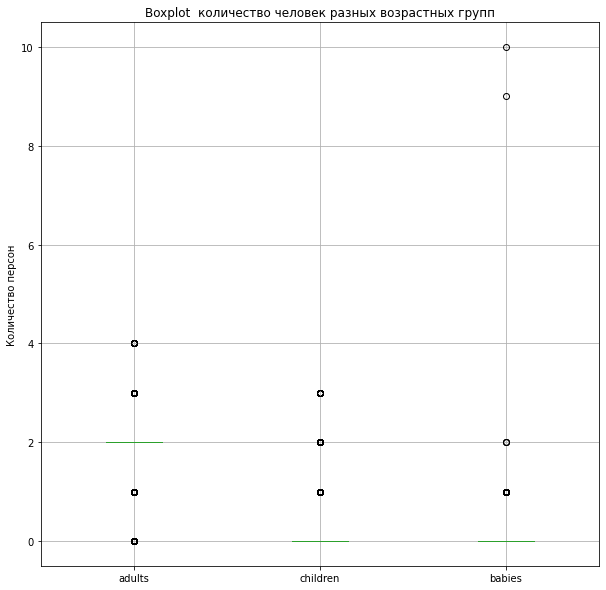

In [14]:
plt.figure(figsize=(10,10))
plt.title('Boxplot  количество человек разных возрастных групп')
plt.ylabel("Количество персон")
print(df[['adults','children','babies']].boxplot())

Как мы можем видеть присутствуют аномальные значения в столбцах `lead_time`, `adults`, `children`,`babies`, `book_changes` и `total_nights`. Можно избавиться от значений в столбце `lead_time` более года (360 дн) и `required_car_parking_spaces>1` более 1

In [15]:
dropping('lead_time>360')

In [16]:
dropping('required_car_parking_spaces>1')

In [17]:
df[['adults','children','babies']].value_counts()

adults  children  babies
2       0         0         45195
1       0         0         12982
3       0         0          2816
2       1         0          1948
        2         0          1124
        0         1           378
0       2         0           138
1       1         0           128
        2         0            60
2       1         1            49
3       1         0            36
0       0         0            15
4       0         0            13
2       2         1            10
0       3         0             8
2       3         0             6
        0         2             3
1       0         1             3
3       0         1             3
0       2         1             3
        1         0             2
1       3         0             2
2       0         10            1
1       0         9             1
3       2         0             1
dtype: int64

Значения в столбце `adults` равные 0 являются аномальными и от них можно избавиться, также как и от количества детей (`babies`) равному 9 и 10, которые встречаются лишь по 1 разу. Также мы можем избавиться от значений в столбце `lead_time` более 360 

In [18]:
dropping('adults<1')
dropping('babies>3')

AxesSubplot(0.125,0.125;0.775x0.755)


total_nights
2               16555
3               15602
1               12091
4                9559
5                4240
7                3842
6                2061
8                 540
9                 151
10                116
dtype: int64

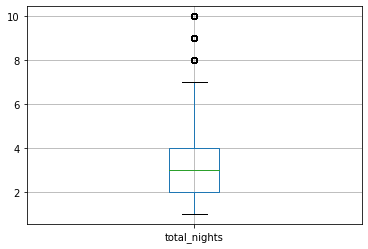

In [19]:
print(df[['total_nights']].boxplot())
df[['total_nights']].value_counts()

Также мы можем избавиться от аномальных значений `total_nights`, равные 8 и более

In [20]:
dropping('total_nights>7')

AxesSubplot(0.125,0.125;0.775x0.755)


booking_changes
0                  55192
1                   6432
2                   1697
3                    385
4                    145
5                     41
6                     17
7                     17
8                      7
9                      5
13                     4
10                     2
14                     2
15                     2
16                     1
17                     1
dtype: int64

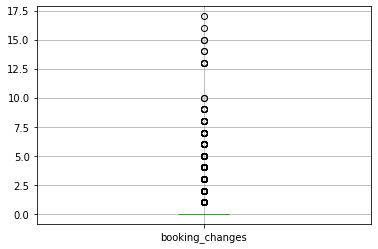

In [21]:
print(df[['booking_changes']].boxplot())
df[['booking_changes']].value_counts()

Значения в столбце `booking_changes` более 2 можно считать аномальными

In [22]:
dropping('booking_changes>2')

In [23]:
df = df.reindex(range(len(df)),method = 'ffill')
df_test = df_test.reindex(range(len(df_test)),method='ffill') #Восстановление индексации после удаления строк

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63321 entries, 0 to 63320
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              63321 non-null  int64 
 1   is_canceled                     63321 non-null  int64 
 2   lead_time                       63321 non-null  int64 
 3   arrival_date_year               63321 non-null  int64 
 4   arrival_date_month              63321 non-null  object
 5   arrival_date_week_number        63321 non-null  int64 
 6   arrival_date_day_of_month       63321 non-null  int64 
 7   stays_in_weekend_nights         63321 non-null  int64 
 8   stays_in_week_nights            63321 non-null  int64 
 9   adults                          63321 non-null  int64 
 10  children                        63321 non-null  int64 
 11  babies                          63321 non-null  int64 
 12  meal                            63321 non-null

In [25]:
x = 65229-63321
print(x/65229*100)

2.9250793358782134


После очистки датафрейма от аномальных значений мы потеряли всего лишь 3% данных

### Формулировка ML-задачи на основе бизнес-задачи

Основная бизнес метрика - прибыль, для этого нам нужно создать новый столбец с данными равными количеству ночей умноженному на цену номера (с учетом сезона) и убрав затраты на уборку. После этого надо посчитать общую сумму прибыли

In [26]:
#Создание новых столбцов изначально с аномально низкими значениями, чтобы после работы функции можно было узнать все ли строки были обработаны
df['room_cost'] = -10000000000000000 # столбец со стоимостью номера
df['season_cost'] = -10000000000000000000 # столбец со стоимостью номера вместе с сезонным увеличением цены
df['service'] = -100000000000000 # столбец со стоимостью разового обслуживания
df['total'] = -1000000000000000 # столбец с итоговой стоимостью
df['total_with_canceled']= -1000000000000000 #Столбец с итоговой прибылью/убытками компании

df_test['room_cost'] = -10000000000000000 # столбец со стоимостью номера
df_test['season_cost'] = -10000000000000000000 # столбец со стоимостью номера вместе с сезонным увеличением цены
df_test['service'] = -100000000000000 # столбец со стоимостью разового обслуживания
df_test['total'] = -1000000000000000 # столбец с итоговой стоимостью
df_test['total_with_canceled'] = -100000000000000 #Столбец с итоговой прибылью/убытками компании

In [27]:
costing(df)

In [28]:
costing(df_test)

In [29]:
display(df_test)
print(df_test.info())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,room_cost,season_cost,service,total,total_with_canceled
0,6086,1,74,2017,January,1,1,1,0,2,...,0,Transient,0,0,1,1000,1000,400,1400,-1400
1,6087,1,62,2017,January,1,1,2,2,2,...,0,Transient,0,1,4,1000,1000,400,4800,-1400
2,6088,1,62,2017,January,1,1,2,2,2,...,0,Transient,0,1,4,600,600,350,3100,-950
3,6089,1,71,2017,January,1,1,2,2,1,...,0,Transient,0,1,4,600,600,350,3100,-950
4,6090,1,172,2017,January,1,1,2,5,2,...,0,Transient,0,0,7,1000,1000,400,8600,-1400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,97899,0,164,2017,August,35,31,2,4,2,...,0,Transient,0,0,6,1000,1400.0,400,9600,9600
32408,97900,0,21,2017,August,35,30,2,5,2,...,0,Transient,0,2,7,1000,1400.0,400,11400,11400
32409,97901,0,23,2017,August,35,30,2,5,2,...,0,Transient,0,0,7,1000,1400.0,400,11400,11400
32410,97902,0,34,2017,August,35,31,2,5,2,...,0,Transient,0,4,7,1000,1400.0,400,11400,11400


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              32412 non-null  int64 
 1   is_canceled                     32412 non-null  int64 
 2   lead_time                       32412 non-null  int64 
 3   arrival_date_year               32412 non-null  int64 
 4   arrival_date_month              32412 non-null  object
 5   arrival_date_week_number        32412 non-null  int64 
 6   arrival_date_day_of_month       32412 non-null  int64 
 7   stays_in_weekend_nights         32412 non-null  int64 
 8   stays_in_week_nights            32412 non-null  int64 
 9   adults                          32412 non-null  int64 
 10  children                        32412 non-null  int64 
 11  babies                          32412 non-null  int64 
 12  meal                            32412 non-null

In [30]:
df['season_cost'] = df['season_cost'].astype(int)
df_test['season_cost'] = df_test['season_cost'].astype(int)

Теперь нужно подсчитать выручку до внедрения системы прогнозов отказов и депозитов, чтобы затем сравнить ее с полученными сейчас реультатами

In [31]:
df_test['total_with_canceled'].sum()

63476269

Итоговый доход, который будет получен без системы депозитов равен 63 476 269 р

### Разработка модели ML

Перед началом обучения нашей модели, нужно перевести категориальные признаки в числовые и отделить признаки от цели.

In [32]:
df = shuffle(df,random_state=12345) #Перемешиваем датафреймы 
df_test = shuffle(df_test,random_state=12345)

In [33]:
df_test

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,room_cost,season_cost,service,total,total_with_canceled
16130,53319,1,343,2017,July,27,2,2,2,2,...,0,Transient,0,0,4,500,700,150,3100,-850
8160,45349,1,29,2017,January,3,16,2,5,2,...,0,Transient,0,1,7,1000,1000,400,8600,-1400
15097,52286,1,173,2017,June,24,11,2,3,2,...,0,Transient,0,0,5,500,700,150,3950,-850
15841,53030,1,138,2017,June,26,27,0,3,2,...,0,Transient,0,0,3,1000,1400,400,4600,-1800
836,6937,1,73,2017,April,15,15,2,1,1,...,0,Transient,0,0,3,550,660,150,2130,-810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19876,85368,0,27,2017,February,6,5,2,2,1,...,0,Transient,0,1,4,1000,1000,400,4800,4800
2177,8359,0,134,2017,April,15,13,0,3,2,...,0,Transient-Party,0,1,3,1000,1200,400,4000,4000
32029,97521,0,174,2017,August,34,20,2,5,2,...,0,Transient-Party,0,0,7,1000,1400,400,11400,11400
11749,48938,1,135,2017,April,16,21,1,2,2,...,0,Transient,0,0,3,500,600,150,1950,-750


In [34]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value = -1) #Порядковое кодирование для моделей RandomForest и DecisionTree
encoder.fit(df) 
df_ohe = pd.DataFrame(encoder.transform(df),columns=df.columns) 
df_ohe_test = pd.DataFrame(encoder.transform(df_test),columns=df_test.columns)

df_lin_ohe = pd.get_dummies(df, drop_first=True) #Прямое кодирование для модели LinearRegression
df_lin_ohe_test = pd.get_dummies(df_test, drop_first=True)

In [35]:
df_ohe['is_canceled'].value_counts()

0.0    39203
1.0    24118
Name: is_canceled, dtype: int64

Дизбаланс у итоговой цели не большой, его можно оставить таким

In [36]:
df_ohe_test

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,room_cost,season_cost,service,total,total_with_canceled
0,-1.0,1.0,342.0,-1.0,5.0,26.0,1.0,2.0,2.0,1.0,...,0.0,2.0,0.0,0.0,3.0,2.0,10.0,0.0,65.0,10.0
1,-1.0,1.0,29.0,-1.0,4.0,2.0,15.0,2.0,5.0,1.0,...,0.0,2.0,0.0,1.0,6.0,6.0,16.0,2.0,119.0,3.0
2,-1.0,1.0,173.0,-1.0,6.0,23.0,10.0,2.0,3.0,1.0,...,0.0,2.0,0.0,0.0,4.0,2.0,10.0,0.0,80.0,10.0
3,-1.0,1.0,138.0,-1.0,6.0,25.0,26.0,0.0,3.0,1.0,...,0.0,2.0,0.0,0.0,2.0,6.0,19.0,2.0,92.0,0.0
4,-1.0,1.0,73.0,-1.0,0.0,14.0,14.0,2.0,1.0,0.0,...,0.0,2.0,0.0,0.0,2.0,3.0,9.0,0.0,42.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32407,-1.0,0.0,27.0,-1.0,3.0,5.0,4.0,2.0,2.0,0.0,...,0.0,2.0,0.0,1.0,3.0,6.0,16.0,2.0,94.0,115.0
32408,-1.0,0.0,134.0,-1.0,0.0,14.0,12.0,0.0,3.0,1.0,...,0.0,3.0,0.0,1.0,2.0,6.0,18.0,2.0,81.0,102.0
32409,-1.0,0.0,174.0,-1.0,1.0,33.0,19.0,2.0,5.0,1.0,...,0.0,3.0,0.0,0.0,6.0,6.0,19.0,2.0,123.0,144.0
32410,-1.0,1.0,135.0,-1.0,0.0,15.0,20.0,1.0,2.0,1.0,...,0.0,2.0,0.0,0.0,2.0,2.0,7.0,0.0,37.0,13.0


In [37]:
features = df_ohe.drop(['id','total_with_canceled','is_canceled','arrival_date_year'],axis=1) #Выделение датафрейма с признаками, убираем цель (is_canceled),
features_test = df_ohe_test.drop(['id','total_with_canceled','is_canceled','arrival_date_year'],axis=1)#столбец с информацией о итоговой сумме уплаты или потерь компании
                                                                  #id пользователя и года бронирования
target = df_ohe['is_canceled']
target_test = df_ohe_test['is_canceled']

#Тоже самое для прямого кодирования
features_lin = df_lin_ohe.drop(['id','total_with_canceled','is_canceled','arrival_date_year'],axis=1) #Выделение датафрейма с признаками, убираем цель (is_canceled),
features_test_lin = df_lin_ohe_test.drop(['id','total_with_canceled','is_canceled','arrival_date_year'],axis=1)#столбец с информацией о итоговой сумме уплаты или потерь компании
                                                                  #id пользователя и года бронирования
target_lin = df_lin_ohe['is_canceled']
target_test_lin = df_lin_ohe_test['is_canceled']

Теперь можно приступать к обучению моделей методом кросс-валидации. Рассматривать степень "успешности" модели мы будем на метрике f1 (так как нам нужно чтобы как можно у большего количетсва потенциально "ненадежных" клиентов мы запросили депозит, но при этом не запрашивали у "надежных" клиентов)

In [38]:
best_depth_tree = -100
best_depth_forest = -100
best_est = -100
best_score_tree=-100
best_score_forest = -100
best_score_regression = -100
best_model_tree = None
best_model_forest = None
best_model_regression = None

In [39]:
tree_model = DecisionTreeClassifier(random_state=12345,class_weight='balanced')
tree_params = {'max_depth': range(1,30)}
tree_grid = GridSearchCV(tree_model, tree_params, cv=6,n_jobs=-1,verbose=True,scoring='f1')
tree_grid.fit(features,target)

Fitting 6 folds for each of 29 candidates, totalling 174 fits


GridSearchCV(cv=6,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=12345),
             n_jobs=-1, param_grid={'max_depth': range(1, 30)}, scoring='f1',
             verbose=True)

In [40]:
print('Лучшая модель дерева показала результат:',tree_grid.best_score_,' при глубине дерева =', tree_grid.best_params_)

Лучшая модель дерева показала результат: 0.8123673579451268  при глубине дерева = {'max_depth': 23}


In [41]:
forest_model = RandomForestClassifier(random_state=12345,class_weight='balanced')
forest_params = {'max_depth': range(10,30), 'n_estimators': range(10,30)}
forest_grid = GridSearchCV(forest_model, forest_params, cv=6,n_jobs=-1,verbose=True,scoring='f1')
forest_grid.fit(features,target)
print('Лучшая модель леса показала результат:',forest_grid.best_score_,' при глубине дерева и количестве деревьев =',
      forest_grid.best_params_)

Fitting 6 folds for each of 400 candidates, totalling 2400 fits
Лучшая модель леса показала результат: 0.8496098886785632  при глубине дерева и количестве деревьев = {'max_depth': 26, 'n_estimators': 25}


In [42]:
best_model_regression = LogisticRegression(random_state=12345, class_weight='balanced',solver='liblinear')
scores = cross_val_score(best_model_regression,features_lin,target_lin,cv=6, scoring='f1')
best_score_regression = scores.mean()
print('Лучший результат модели регрессии',best_score_regression)

Лучший результат модели регрессии 0.7329113241975783


По итогу лучше всего себя показала модель RandomForestClassifier c глубиной 26 и 25 деревьями


In [43]:
predictions = forest_grid.predict(features_test)
f1 = f1_score(target_test,predictions)
auc = roc_auc_score(target_test,predictions)
print('Значение f1 метрики на тестовой выборке',f1)
print('Значения roc_auc на тестовой выборке',auc)

Значение f1 метрики на тестовой выборке 0.5488586817132598
Значения roc_auc на тестовой выборке 0.6732524921011842


Значение AUC-ROC: 0.7789478380148186


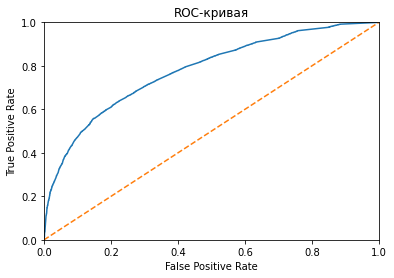

In [44]:
roc(forest_grid,features_test,target_test)

In [45]:
df_test['predictions'] = predictions
df_test['total_with_depos'] = -10000000000
for i in range(len(df_test)):
    if df_test['predictions'][i]>0:
        if df_test['total_with_canceled'][i]<0:
            df_test['total_with_depos'][i] = df_test['total_with_canceled'][i]+df_test['service'][i]+df_test['season_cost'][i]*0.8
        else:
            df_test['total_with_depos'][i] = df_test['total_with_canceled'][i]
    else:
        df_test['total_with_depos'][i] = df_test['total_with_canceled'][i]

In [46]:
df_test

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,required_car_parking_spaces,total_of_special_requests,total_nights,room_cost,season_cost,service,total,total_with_canceled,predictions,total_with_depos
16130,53319,1,343,2017,July,27,2,2,2,2,...,0,0,4,500,700,150,3100,-850,0.0,-850
8160,45349,1,29,2017,January,3,16,2,5,2,...,0,1,7,1000,1000,400,8600,-1400,1.0,-200
15097,52286,1,173,2017,June,24,11,2,3,2,...,0,0,5,500,700,150,3950,-850,1.0,-140
15841,53030,1,138,2017,June,26,27,0,3,2,...,0,0,3,1000,1400,400,4600,-1800,1.0,-280
836,6937,1,73,2017,April,15,15,2,1,1,...,0,0,3,550,660,150,2130,-810,0.0,-810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19876,85368,0,27,2017,February,6,5,2,2,1,...,0,1,4,1000,1000,400,4800,4800,0.0,4800
2177,8359,0,134,2017,April,15,13,0,3,2,...,0,1,3,1000,1200,400,4000,4000,0.0,4000
32029,97521,0,174,2017,August,34,20,2,5,2,...,0,0,7,1000,1400,400,11400,11400,0.0,11400
11749,48938,1,135,2017,April,16,21,1,2,2,...,0,0,3,500,600,150,1950,-750,1.0,-120


In [47]:
df_test['total_with_depos'].sum()-df_test['total_with_canceled'].sum()-400000

5802332

Данная модель отобьет затраты на разработку и принесет прибыль 5 802 332

### Описание портрета «ненадёжного» клиента

In [48]:
df.corr()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,room_cost,season_cost,service,total,total_with_canceled
id,1.000000,-0.218479,0.024508,0.229890,0.004856,-0.006897,-0.091055,-0.157118,0.004521,-0.005388,...,-0.000893,-0.016311,-0.114008,0.112981,-0.170016,0.110419,0.139841,0.093664,-0.099087,0.132606
is_canceled,-0.218479,1.000000,0.331154,-0.014314,0.045496,0.004880,-0.010243,0.018344,0.046663,-0.011652,...,-0.164435,0.070957,-0.193311,-0.255790,0.009415,0.082947,0.080886,0.080250,0.035586,-0.812573
lead_time,0.024508,0.331154,1.000000,-0.022700,0.106831,-0.010718,0.045253,0.175548,0.126955,-0.057176,...,-0.025022,0.216975,-0.124288,-0.149037,0.161725,0.137726,0.217362,0.134941,0.221785,-0.166427
arrival_date_year,0.229890,-0.014314,-0.022700,1.000000,-0.429581,0.004524,-0.008900,0.013161,0.034213,0.049635,...,0.030824,0.032106,0.018398,0.083766,0.005980,-0.109999,-0.119432,-0.114609,-0.046151,-0.004048
arrival_date_week_number,0.004856,0.045496,0.106831,-0.429581,1.000000,0.034869,0.036448,0.037325,0.003127,-0.012984,...,-0.002143,-0.045390,-0.003910,0.064377,0.047795,0.006528,0.030790,0.005589,0.050955,-0.010109
arrival_date_day_of_month,-0.006897,0.004880,-0.010718,0.004524,0.034869,1.000000,-0.002908,0.005429,0.007518,0.017260,...,0.014856,0.018308,0.004137,0.002355,0.002848,-0.020667,-0.023019,-0.019663,-0.008376,-0.004774
stays_in_weekend_nights,-0.091055,-0.010243,0.045253,-0.008900,0.036448,-0.002908,1.000000,0.154306,0.129449,0.028442,...,0.022618,-0.062715,-0.017086,0.080004,0.622138,-0.103713,-0.080185,-0.102810,0.531365,0.256661
stays_in_week_nights,-0.157118,0.018344,0.175548,0.013161,0.037325,0.005429,0.154306,1.000000,0.126124,0.025205,...,0.043878,0.044542,-0.033562,0.084032,0.869530,-0.156123,-0.114765,-0.157683,0.737239,0.342458
adults,0.004521,0.046663,0.126955,0.034213,0.003127,0.007518,0.129449,0.126124,1.000000,0.051080,...,-0.073790,-0.015547,0.011212,0.179450,0.164648,-0.234488,-0.161122,-0.237595,0.072748,0.018638
children,-0.005388,-0.011652,-0.057176,0.049635,-0.012984,0.017260,0.028442,0.025205,0.051080,1.000000,...,0.045225,-0.038240,0.055938,0.103900,0.034189,-0.272341,-0.229956,-0.200103,-0.068237,-0.011526


In [49]:
pd.set_option('display.max_columns', 40)
df.query('is_canceled==1').describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,room_cost,season_cost,service,total,total_with_canceled
count,24118.000000,24118.0,24118.000000,24118.000000,24118.000000,24118.000000,24118.000000,24118.000000,24118.000000,24118.000000,24118.000000,24118.000000,24118.000000,24118.000000,24118.000000,24118.000000,24118.0,24118.000000,24118.000000,24118.000000,24118.000000,24118.000000,24118.000000,24118.000000
mean,35377.305747,1.0,136.632266,2015.702214,31.538021,15.812381,0.798574,2.224645,1.870056,0.064972,0.003234,0.018244,0.323037,0.028858,0.064806,5.146695,0.0,0.258065,3.023219,916.328054,1123.306369,356.814412,3850.112198,-1480.122730
std,17555.197841,0.0,104.502879,0.457294,12.827378,8.723033,0.832426,1.247278,0.432093,0.317503,0.056778,0.133834,1.523927,0.816342,0.294924,20.739549,0.0,0.594853,1.568613,180.748745,251.495334,93.922716,2118.776058,336.317597
min,4.000000,1.0,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,350.000000,350.000000,150.000000,500.000000,-1800.000000
25%,29356.250000,1.0,45.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.000000,1000.000000,1000.000000,400.000000,2590.000000,-1600.000000
50%,37543.500000,1.0,106.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.000000,1000.000000,1200.000000,400.000000,3200.000000,-1600.000000
75%,43741.750000,1.0,220.000000,2016.000000,42.000000,24.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,4.000000,1000.000000,1200.000000,400.000000,4600.000000,-1400.000000
max,79128.000000,1.0,360.000000,2016.000000,53.000000,31.000000,2.000000,5.000000,4.000000,3.000000,1.000000,1.000000,26.000000,58.000000,2.000000,236.000000,0.0,4.000000,7.000000,1000.000000,1400.000000,400.000000,11400.000000,-500.000000


In [50]:
pd.set_option('display.max_columns', 40)
df.query('is_canceled==0').describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,room_cost,season_cost,service,total,total_with_canceled
count,39203.000000,39203.0,39203.000000,39203.000000,39203.000000,39203.000000,39203.000000,39203.000000,39203.000000,39203.000000,39203.000000,39203.000000,39203.000000,39203.000000,39203.000000,39203.000000,39203.000000,39203.000000,39203.00000,39203.000000,39203.000000,39203.000000,39203.000000,39203.000000
mean,46648.116879,0.0,71.385455,2015.715583,30.297018,15.724664,0.816111,2.174859,1.824962,0.072673,0.008928,0.033645,0.016861,0.161569,0.209958,2.425503,0.092493,0.650409,2.99097,882.758973,1078.924343,339.979083,3687.675739,3687.675739
std,27851.196291,0.0,80.289295,0.451142,13.475719,8.730993,0.830754,1.359346,0.489961,0.323002,0.094876,0.180317,0.323235,1.581039,0.485041,17.110031,0.289724,0.787281,1.71887,204.590686,273.888939,105.963549,2272.493505,2272.493505
min,0.000000,0.0,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,350.000000,350.000000,150.000000,500.000000,500.000000
25%,16907.500000,0.0,8.000000,2015.000000,19.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.00000,800.000000,1000.000000,350.000000,1800.000000,1800.000000
50%,60394.000000,0.0,41.000000,2016.000000,33.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.00000,1000.000000,1200.000000,400.000000,3200.000000,3200.000000
75%,72087.500000,0.0,109.000000,2016.000000,41.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.00000,1000.000000,1200.000000,400.000000,4600.000000,4600.000000
max,82024.000000,0.0,359.000000,2016.000000,53.000000,31.000000,2.000000,5.000000,4.000000,3.000000,2.000000,1.000000,13.000000,55.000000,2.000000,259.000000,1.000000,5.000000,7.00000,1000.000000,1400.000000,400.000000,11400.000000,11400.000000


Исходя из корреляции отмененных броней с другими данными и средними/медианными значениями отмененных и неотмененных броней можно сделать вывод, что "ненадежные" клиенты чаще бронируют номер заранее (на 100 и более дней), с большей вероятностью мы можем предположить, что если человек делает бронь намного вперед, то он отменит бронь. Также чем больше специальных пометок, тем меньше шанс что человек отменит бронь. Такая же зависимость есть между необходимостью места для машины и отменой брони.(если есть необходимость, тем меньше шанс отмены). Также есть небольшая зависимость между стоимостью номера и отменой брони (чем больше стоит номер, тем больше шанс отмены). Ну и конечно, есть связь между предыдущими отменами и вероятной отменой, если раньше человек отменял бронь, то с большей вероятностью он сделает это снова).

По итогу о "ненадежный" клиент скорее всего:
- бронирует номер за более чем 100 дней
- ранее уже отменял брони
- не нуждается в парковочном месте
- не имеет специальных пометок
- выбирает более дорогой номер
- не посещал отель ранее
- изменял параметры заказа
- несколько дней ожидал подтверждения заказа

### Общий вывод

Лучшей моделью показала себя RandomForestClassifier с 25 деревьями и 26 глубиной на каждом. Если использовать данную модель для системы внедрения депозитов, то в тестовый период она окупится и принесет прибыль. (на тестовых данных прибыль увеличилась на 5,8 млн)

Бизнесу можно рекоммендовать на основе данной модели ввести систему депозитов и более внимательно относиться к клиентами попавших в описание "ненадежного", особенно на тех кто бронирует номер за 100 и более дней и имел предыдущие отмены.